In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import pickle
from copy import deepcopy
from collections import OrderedDict
import sys
import json

from pymongo import MongoClient

import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentAnalyzer
from nltk.stem import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.externals import joblib

from textblob import TextBlob

import gensim
from gensim.models import *
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
from bqplot import pyplot as plt2
import seaborn as sns

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/bqplot/scales.py:433: DeprecationWarning: metadata {'args': (None,)} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  min = Date(default_value=None, allow_none=True).tag(sync=True)
/home/ubuntu/anaconda3/lib/pyt

In [177]:
mng_client = MongoClient()
mng_db = mng_client['news_db']
news_collection = mng_db.news_collection

In [5]:
#find all instances of NYT articles in the mongodb and add them to a list
nytimes = []
articles = news_collection.find({'publication':'New York Times'})
for document in articles:
    nytimes.append(document)

In [6]:
#create a dataframe from the list of nytimes articles
df_nyt = pd.DataFrame(nytimes)

In [ ]:
#show the head of the dataframe
df_nyt.head()

In [ ]:
#show the number of articles in the dataframe
len(df_nyt)

In [ ]:
#show the years for the articles
df_nyt['year'].value_counts()

In [7]:
#2015 and 2014 only have a total of 4 articles out of 7803. remove them.
df_nyt = df_nyt[df_nyt['year'] != 2015.0]
df_nyt = df_nyt[df_nyt['year'] != 2014.0]

In [ ]:
df_nyt['year'].value_counts()

In [192]:
#create a function of stopwords for later removing stopwords from articles
def get_stopwords():    
    #Create a set of stop words to pull out of the dataset
    stop = stopwords.words('english')
    stop.append("new")
    stop.append("like")
    stop.append("u")
    stop.append("it")
    stop.append("s")
    stop.append("n")
    stop.append("t")
    stop.append('mr')
    stop.append('ms')
    stop.append('mrs')
    stop.append('Mr')
    stop.append('Ms')
    stop.append('Mrs')
    stop.append('said')
    stop.append('one')
    stop = set(stop)
    return (stop)

In [195]:
def clean_data(df):
    stop = get_stopwords()
    stemmer = SnowballStemmer('english')
    #df['sentences'] = df.content.apply(sent_tokenize)
    #df['sentences'] = [[re.sub("[^a-zA-Z0-9]+", ' ',s) for s in item] for item in df['sentences']]
    #df['sent_length'] = df.apply(lambda row: len(row['sentences']),axis=1)
    df['no_punc'] = [re.sub("[^a-zA-Z0-9]+", ' ',s) for s in df['content']] 
    df['text_stem'] = df['no_punc'].apply(stemmer.stem)
    df['text_clean_stem'] = df['text_stem'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    #df['words'] = df.text_clean_stem.apply(word_tokenize)
    #df['word_pos'] = df.text_clean_stem.apply(word_tokenize).apply(pos_tag)
    return df

In [10]:
df_nyt = clean_data(df_nyt)

In [11]:
df_nyt.head()

_id                         author  \
0  5b0329e49959af5ca4022a43                     Carl Hulse   
1  5b0329e49959af5ca4022a44  Benjamin Mueller and Al Baker   
2  5b0329e49959af5ca4022a45                   Margalit Fox   
3  5b0329e49959af5ca4022a46               William McDonald   
4  5b0329e49959af5ca4022a47                  Choe Sang-Hun   

                                             content        date     id  \
0  WASHINGTON  —   Congressional Republicans have...  2016-12-31  17283   
1  After the bullet shells get counted, the blood...  2017-06-19  17284   
2  When Walt Disney’s “Bambi” opened in 1942, cri...  2017-01-06  17285   
3  Death may be the great equalizer, but it isn’t...  2017-04-10  17286   
4  SEOUL, South Korea  —   North Korea’s leader, ...  2017-01-02  17287   

   month     publication                                              title  \
0   12.0  New York Times  House Republicans Fret About Winning Their Hea...   
1    6.0  New York Times  Rift Between Officers and Residents as Killing...   
2    1.0  New York Times  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
3    4.0  New York Times  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
4    1.0  New York Times  Kim Jong-un Says North Korea Is Preparing to T...   

    url    year                                          sentences  \
0  None  2016.0  [WASHINGTON Congressional Republicans have a n...   
1  None  2017.0  [After the bullet shells get counted the blood...   
2  None  2017.0  [When Walt Disney s Bambi opened in 1942 criti...   
3  None  2017.0  [Death may be the great equalizer but it isn t...   
4  None  2017.0  [SEOUL South Korea North Korea s leader Kim sa...   

   sent_length                                            no_punc  \
0           26  WASHINGTON Congressional Republicans have a ne...   
1          215  After the bullet shells get counted the blood ...   
2          115  When Walt Disney s Bambi opened in 1942 critic...   
3           79  Death may be the great equalizer but it isn t ...   
4           25  SEOUL South Korea North Korea s leader Kim sai...   

                                           text_stem  \
0  washington congressional republicans have a ne...   
1  after the bullet shells get counted the blood ...   
2  when walt disney s bambi opened in 1942 critic...   
3  death may be the great equalizer but it isn t ...   
4  seoul south korea north korea s leader kim sai...   

                                     text_clean_stem  \
0  washington congressional republicans fear come...   
1  bullet shells get counted blood dries votive c...   
2  walt disney bambi opened 1942 critics praised ...   
3  death may great equalizer necessarily evenhand...   
4  seoul south korea north korea leader kim sunda...   

                                               words  \
0  [washington, congressional, republicans, fear,...   
1  [bullet, shells, get, counted, blood, dries, v...   
2  [walt, disney, bambi, opened, 1942, critics, p...   
3  [death, may, great, equalizer, necessarily, ev...   
4  [seoul, south, korea, north, korea, leader, ki...   

                                            word_pos  
0  [(washington, JJ), (congressional, JJ), (repub...  
1  [(bullet, NN), (shells, NNS), (get, VBP), (cou...  
2  [(walt, NN), (disney, NN), (bambi, NN), (opene...  
3  [(death, NN), (may, MD), (great, JJ), (equaliz...  
4  [(seoul, NN), (south, JJ), (korea, JJ), (north...

In [2]:
#save the dataframe as a pkl file for later recall
#df_nyt.to_pickle('nyt_df.pkl')
#read the dataframe from a pkl file
df_nyt = pd.read_pickle('nyt_df.pkl')

### Word2Vec

In [ ]:
#create a model using word2vec for the words in the df_nyt corpus.
model = gensim.models.Word2Vec(df_nyt['words'], size=100, window=5, min_count=10, workers=8, iter=10, sg=1)

In [ ]:
#save the word2vec model
#model.save('word2vec_model.model')
#load the word2vec model
#model = Word2Vec.load('word2vec_model.model')

In [ ]:
#use this to identify similar words
model.wv.most_similar('trump')

In [ ]:
#create a variable to use for a kmeans model, it is an array of vectors for each word in the model vocab
model_kmeans = model[model.wv.vocab]

In [ ]:
#example vector for the first word in the vocab
model_kmeans[0]

In [ ]:
#create a kmeans cluster using word vectors for words in the vocab based on the word-vec model
word_vec = model.wv.syn0
num_clusters = 80
kmeans_cluster = KMeans(num_clusters)
idx = kmeans_cluster.fit_predict(word_vec)

In [ ]:
word_cent = list(zip(model.wv.index2word, idx))

In [ ]:
#print out the words in each cluster
for cluster in range(num_clusters):
    print('\ncluster %d'%cluster)
    words=[]
    for i in range(0,len(word_cent)):
        if(word_cent[i][1] ==cluster):
            words.append(word_cent[i][0])
    print (words)

### End of Word2Vec

### Start LDA and KMeans Clustering

In [206]:
vectorizer = CountVectorizer(min_df=5, ngram_range=(1,3), max_df=.90, max_features = 20000)

In [207]:
nyt_vect = vectorizer.fit_transform(df_nyt['text_clean_stem'])

In [208]:
nyt_vect.shape

(7799, 20000)

In [10]:
len(df_nyt['text_clean_stem'][0])

3988

In [5]:
df_nyt['text_clean_stem'][0]

'washington congressional republicans fear comes health care lawsuit obama administration might win incoming trump administration could choose longer defend executive branch suit challenges administration authority spend billions dollars health insurance subsidies americans handing house republicans big victory issues sudden loss disputed subsidies could conceivably cause health care program implode leaving millions people without access health insurance republicans prepared replacement could lead chaos insurance market spur political backlash republicans gain full control government stave outcome republicans could find awkward position appropriating huge sums temporarily prop obama health care law angering conservative voters demanding end law years another twist donald j trump administration worried preserving executive branch prerogatives could choose fight republican allies house central questions dispute eager avoid ugly political pileup republicans capitol hill trump transition t

In [ ]:
#dump the vectorizer and nyt_vect into pkl files
#joblib.dump(vectorizer, 'vectorizer.pkl')
#joblib.dump(nyt_vect, 'nyt_vect.pkl')

In [ ]:
#vectorizer = joblib.load('vectorizer.pkl')
#nyt_vect = joblib.load('nyt_vect.pkl')

In [13]:
num_components = 60

In [9]:
lda = LatentDirichletAllocation(n_components=num_components, 
                                max_iter=7,
                                learning_method='online',
                                learning_offset=10.,
                                learning_decay=.7,
                                n_jobs=-1,
                                random_state=42)

In [10]:
lda.fit(nyt_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=7, mean_change_tol=0.001,
             n_components=60, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [111]:
lda_topics = lda.transform(nyt_vect)

lda_topics[0].argmax()

category = []
for i in lda_topics:
    category.append(i.argmax())

df_nyt['lda_cats'] = category

df_nyt['lda_cats'].value_counts()

In [ ]:
#save the lda model to lda_nyt as a pkl file
#joblib.dump(lda, 'lda_nyt.pkl')
#load the model from the pickle file
#lda = joblib.load('lda_nyt.pkl')

In [34]:
vocab = vectorizer.get_feature_names()

In [35]:
for topic in range(num_components):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
miami
dallas
brown
yards
bay
seattle
quarterback
pittsburgh
atlanta
cowboys

TOPIC 1
team
game
players
season
first
two
games
last
league
win

TOPIC 2
hastert
estonia
rusbridger
estonian
lupone
luik
tallinn
captain khan
dr bardack
dr oz

TOPIC 3
mexico
prison
brazil
de
drug
inmates
mexican
brazilian
gang
governor

TOPIC 4
flight
airport
travel
plane
passengers
air
airlines
airline
aircraft
travelers

TOPIC 5
moore
mary
tyler
sanders campaign
richards
quincea
dyke
yevtushenko
van dyke
quincea era

TOPIC 6
tebow
gurley
keillor
star trek
castillo
buffy
ayers
prairie home
mauna
bad moms

TOPIC 7
redstone
viacom
dauman
sudan
kosovo
davao
south sudan
squad
hacking team
herzer

TOPIC 8
wilmore
bitcoin
clinical trials
bello
biotech
innate
venezuelans
gottlieb
jason bourne
dr gottlieb

TOPIC 9
myanmar
san
aung
suu
kyi
suu kyi
aung san
san suu
san suu kyi
aung san suu

TOPIC 10
metropoulos
belldegrun
dr june
playboy mansion
cell therapy
redstone
therapeutics
amusements
immune cells
dr ro

In [113]:
df_nyt[df_nyt['lda_cats'] ==12]

In [21]:
lda.perplexity(nyt_vect)

7962.639599605149

### Explore pyLDAvis visualization for this dataset

In [ ]:
nyt_vect.shape

In [ ]:
#dump the vectorizer and nyt_vect into pkl files
#joblib.dump(lda_tf, 'lda_tf.pkl')
#load the model from the pickle file
#lda_tf = joblib.load('lda_tf.pkl')


In [25]:
pyLDAvis.sklearn.prepare(lda, nyt_vect, vectorizer)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.122338 -0.227015       1        1  17.402787
11     0.157324 -0.205885       2        1  14.563803
23     0.167758 -0.213918       3        1  11.448180
27     0.207493 -0.203164       4        1  10.101751
22     0.186212 -0.195784       5        1   7.506145
13     0.215241 -0.139732       6        1   6.738931
20     0.184938 -0.186216       7        1   5.484381
41     0.258343 -0.112543       8        1   5.204888
32     0.244170 -0.114383       9        1   4.416325
17     0.257858 -0.102335      10        1   2.873876
1      0.254240 -0.128122      11        1   2.642727
56     0.236126 -0.027472      12        1   1.923297
37     0.228404  0.060090      13        1   1.671416
42     0.238746  0.002855      14        1   1.073646
34     0.243504  0.026643      15        1   1.062091
35     0.213518  0.045936      16        1   0.736096
33     0.213852  0.048780      17        1   0.529426
43     0.147835  0.172359      18        1   0.478903
38     0.113884  0.145619      19        1   0.456350
12     0.146240  0.163659      20        1   0.436712
3      0.114409  0.162558      21        1   0.355122
54     0.110667  0.146352      22        1   0.322412
48     0.100203  0.147828      23        1   0.311507
39     0.136350  0.123714      24        1   0.302895
58     0.102345  0.150326      25        1   0.298611
4      0.084464  0.178402      26        1   0.259270
40     0.069785  0.163175      27        1   0.202811
57     0.038361  0.159244      28        1   0.179968
46     0.022369  0.150445      29        1   0.149141
0     -0.018130  0.135977      30        1   0.117991
15    -0.044557  0.114579      31        1   0.092945
47    -0.038548  0.128344      32        1   0.091747
29    -0.053085  0.110737      33        1   0.082995
53    -0.072195  0.100092      34        1   0.071371
49    -0.105312  0.071233      35        1   0.053913
51    -0.117361  0.056083      36        1   0.044991
50    -0.136558  0.036360      37        1   0.037833
7     -0.150203  0.017650      38        1   0.030336
9     -0.155326  0.012723      39        1   0.026212
5     -0.165705 -0.001484      40        1   0.023952
30    -0.171941 -0.010717      41        1   0.020466
25    -0.167784 -0.003848      42        1   0.019370
8     -0.183347 -0.032098      43        1   0.014774
55    -0.185109 -0.033711      44        1   0.014050
14    -0.182141 -0.028353      45        1   0.014049
19    -0.184751 -0.032826      46        1   0.012699
21    -0.185083 -0.034130      47        1   0.012221
2     -0.188234 -0.041536      48        1   0.010907
6     -0.189898 -0.046529      49        1   0.010043
59    -0.192226 -0.054795      50        1   0.008354
31    -0.192113 -0.055110      51        1   0.007708
52    -0.192921 -0.059105      52        1   0.007177
16    -0.193122 -0.060700      53        1   0.006652
28    -0.193166 -0.061208      54        1   0.006542
45    -0.193238 -0.061979      55        1   0.006412
24    -0.193382 -0.067053      56        1   0.005078
10    -0.193277 -0.069411      57        1   0.004468
44    -0.193130 -0.071380      58        1   0.004218
36    -0.193069 -0.071791      59        1   0.004169
26    -0.192061 -0.077430      60        1   0.002890, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
44984  Default  31537.000000          trump  31537.000000  30.0000  30.0000
44095  Default   6053.000000          times   6053.000000  29.0000  29.0000
48766  Default   5477.000000          women   5477.000000  28.0000  28.0000
39504  Default   4589.000000           show   4589.000000  27.0000  27.0000
46255  Default  10276.000000         united  10276.000000  26.0000  26.0000
9315   Default   6628.000000        company   6628.000000  25.0000  25.0000
3

### Trying to cluster documents into topics

In [399]:
dtm = nyt_vect.asfptype()

In [426]:
#use truncatedSVD to ... do stuff... rewrite this after I run the cell.
lsa = TruncatedSVD(60, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [425]:
#dig more into this
explained_variance = lsa.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

  Explained variance of the SVD step: 33%


In [404]:
km_clus = KMeans(n_clusters = 60, init='k-means++', max_iter=400, n_jobs=-1, verbose=0)

In [405]:
km_clus.fit(dtm_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=400,
    n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [338]:
#save the kmeans model to km_clus as a pkl file
#joblib.dump(km_clus, 'km_clus.pkl')
#df_nyt.to_pickle('df_nyt.pkl')

['km_clus.pkl']

In [417]:
#load in the km_cluster model and df_nyt
km_clus = joblib.load('km_clus.pkl')
#df_nyt = pd.read_pickle('df_nyt.pkl')

In [427]:
predicted_cluster = km_clus.predict(dtm_lsa)

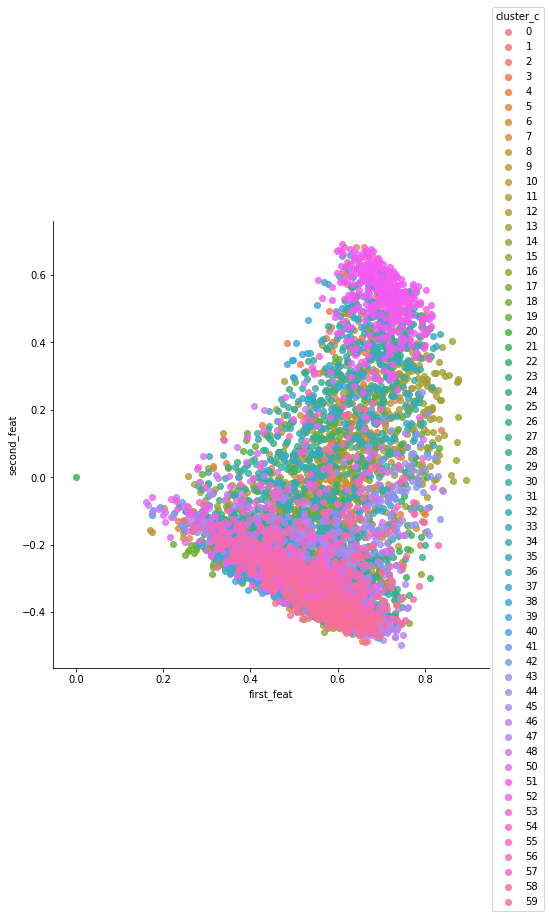

In [428]:
df = pd.DataFrame(dtm_lsa[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 7)

In [429]:
original_space_centroids = lsa.inverse_transform(km_clus.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [430]:
cluster_num = 60

In [431]:
terms = vectorizer.get_feature_names()

In [432]:
#dictionary = {}
for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :10]:
        #if i in dictionary:
        #    dictionary[i].append(terms[ind])
        #else:
        #    dictionary[i] = [terms[ind]]
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
        
    print(" ")
    print(" ")
print()

Cluster 0: 
 trump
 republican
 party
 campaign
 would
 republicans
 democrats
 clinton
 voters
 senator
 
 
Cluster 1: 
 government
 people
 united
 syria
 would
 military
 syrian
 many
 country
 forces
 
 
Cluster 2: 
 water
 people
 would
 city
 last
 could
 two
 year
 years
 officials
 
 
Cluster 3: 
 trump
 clinton
 voters
 percent
 would
 state
 party
 obama
 white
 states
 
 
Cluster 4: 
 years
 show
 first
 two
 also
 time
 year
 last
 even
 york
 
 
Cluster 5: 
 black
 white
 people
 also
 show
 many
 women
 time
 would
 even
 
 
Cluster 6: 
 company
 also
 people
 google
 time
 could
 apple
 would
 companies
 many
 
 
Cluster 7: 
 united
 states
 game
 team
 first
 united states
 russia
 would
 women
 world
 
 
Cluster 8: 
 trump
 year
 briefing
 last
 people
 want
 may
 house
 000
 obama
 
 
Cluster 9: 
 united
 states
 united states
 american
 trump
 would
 people
 president
 also
 country
 
 
Cluster 10: 
 city
 people
 york
 time
 would
 also
 two
 million
 work
 year
 
 

In [397]:
#with open('keywords.pkl', 'wb') as file:
#    pickle.dump(dictionary, file)

In [433]:
label = km_clus.labels_

In [ ]:
df_nyt['label'] = label

In [222]:
#create datetime variable from date, set datetime to start of week for given date
df_nyt['datetime'] = pd.to_datetime(df_nyt['date'])
a = df_nyt['datetime'] - pd.offsets.Week(weekday=6)
m1 = df_nyt['datetime'] != (a + pd.offsets.Week())
df_nyt['datetime'] = df_nyt['datetime'].mask(m1,a)

In [366]:
df_nyt.to_pickle('df_nyt_final.pkl')

In [276]:
#df_nyt['counts'] = df_nyt.groupby(['label','datetime'])['datetime'].transform('count')

In [273]:
#df_nyt[df_nyt['label'] ==22].plot(x='datetime', y='counts')

In [274]:
#df_nyt[df_nyt['label'] ==13].plot(x='datetime', y='counts')

In [275]:
#df_nyt[df_nyt['label'] ==28].plot(x='datetime', y='counts')

### Exploring plotly and cufflinks

In [224]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [226]:
df_plot = df_nyt[['label','datetime']]

In [356]:
df_big = df_nyt.loc[df_nyt['label'].isin([31,7,47,40,11,1,3,8,9,26])][['label','datetime']]
testdf = pd.get_dummies(df_big['label'])

testdf2 = df_plot.join(testdf)

testdf2.dropna(inplace=True)

labe = testdf2['label']
col2 = testdf2.columns.tolist()
col2.remove('label')
col2.remove('datetime')

testdf3 = testdf2.groupby('datetime')[col2].sum()

In [398]:
testdf3.iplot()

### End of Plotly Vis

### See how guardian data fits in already built vectors and models

In [188]:
guardian = []
articles = news_collection.find({'publication':'Guardian', 'year':2016.0})
for document in articles:
    guardian.append(document)
articles = news_collection.find({'publication':'Guardian', 'year':2017.0})
for document in articles:
    guardian.append(document)

In [189]:
df_guard = pd.DataFrame(guardian)

In [196]:
df_guard = clean_data(df_guard)

In [241]:
#create datetime variable from date, set datetime to start of week for given date
df_guard['datetime'] = pd.to_datetime(df_guard['date'])
a = df_guard['datetime'] - pd.offsets.Week(weekday=6)
m1 = df_guard['datetime'] != (a + pd.offsets.Week())
df_guard['datetime'] = df_guard['datetime'].mask(m1,a)

In [229]:
guard_vect = vectorizer.transform(df_guard['text_clean_stem'])

In [230]:
guard_vect.shape

(8624, 20000)

In [236]:
dtm2 = guard_vect.asfptype()
guard_dtm = lsa.transform(dtm2)
guard_dtm = Normalizer(copy=False).transform(guard_dtm)

In [280]:
guard_clus = km_clus.predict(guard_dtm)

In [281]:
df_guard['label'] = guard_clus

In [352]:
df_big = df_guard.loc[df_guard['label'].isin([31,7,35,47,40,11,1,51,3,8,9,29,7,26])][['label','datetime']]
testdf = pd.get_dummies(df_big['label'])

testdf2 = df_plot.join(testdf)

testdf2.dropna(inplace=True)

labe = testdf2['label']
col2 = testdf2.columns.tolist()
col2.remove('label')
col2.remove('datetime')

testdf3 = testdf2.groupby('datetime')[col2].sum()

In [353]:
testdf3.iplot()

In [340]:
df_nyt['label'].value_counts()

51    313
28    299
31    237
18    226
29    221
13    217
56    211
22    206
40    200
8     198
4     195
9     192
59    191
46    191
10    191
50    188
44    184
2     180
16    175
11    152
42    146
39    144
55    139
30    134
53    130
23    126
36    125
0     122
7     122
14    117
19    114
26    113
6     109
21    109
57    107
33    104
15    103
34    102
20     96
48     94
32     94
12     86
58     86
25     79
27     79
3      79
1      77
5      77
37     73
17     70
43     67
45     60
54     58
24     56
47     53
35     43
38     40
52     38
49     34
41     27
Name: label, dtype: int64

In [327]:
df_guard['label'].value_counts()

31    753
28    618
22    529
13    405
16    395
46    391
51    379
15    269
18    260
29    242
4     240
50    230
44    228
2     190
42    179
10    172
59    167
39    149
48    147
5     147
58    142
34    140
14    137
36    122
6     119
56    111
55    101
26     96
32     96
7      94
11     88
1      88
12     88
0      76
19     75
30     75
20     68
53     68
47     62
9      62
23     60
40     56
21     55
3      52
33     51
57     51
25     47
38     36
54     36
27     36
24     32
37     30
52     21
35     20
17     17
41     13
45      7
43      3
49      2
8       1
Name: label, dtype: int64

In [328]:
for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 trump
 party
 republican
 campaign
 would
 republicans
 clinton
 democrats
 political
 state
 
 
Cluster 1: 
 government
 people
 syria
 united
 syrian
 city
 military
 russia
 forces
 war
 
 
Cluster 2: 
 water
 people
 would
 city
 also
 two
 officials
 could
 state
 years
 
 
Cluster 3: 
 trump
 clinton
 voters
 percent
 state
 would
 among
 states
 republican
 election
 
 
Cluster 4: 
 time
 years
 first
 also
 show
 two
 work
 year
 art
 last
 
 
Cluster 5: 
 black
 white
 people
 also
 time
 would
 women
 first
 show
 years
 
 
Cluster 6: 
 company
 also
 google
 apple
 could
 people
 many
 would
 companies
 even
 
 
Cluster 7: 
 united
 team
 world
 athletes
 states
 united states
 olympic
 games
 two
 first
 
 
Cluster 8: 
 briefing
 trump
 want
 last
 posted
 briefing posted
 eastern
 back
 people
 may
 
 
Cluster 9: 
 united
 states
 united states
 american
 trump
 would
 people
 president
 also
 country
 
 
Cluster 10: 
 city
 york
 people
 would
 many
 years
 t

In [347]:
#0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59